In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import random
import time
from collections import deque

import gym
import numpy as np

import tensorflow as tf

np.set_printoptions(precision=3, suppress=True, threshold=10000, linewidth=250)

TensorFlow 1.x selected.


**DQN Problem **

 Choose one of the hyperparameter types you want in the following list,


1. self.batch_size = 64
2. self.epsilon = 1.0 
3. upate frequency of the target q network:
```
            if episode % 10 == 0: # an example.
                self.update_target_q_weights()
```
4. the number of hidden units for the q network

and train the agent over different values of the selected hyperparameter type.
For example, if you selected the hyperparameter #2, then you might want to change the values over 0.1 ~ 1.0.
In other words, if you train the agent on epsilon=0.1, 0.2,...,1.0, 
it might result in 10 different training instances and the corresponding learning curves (10 curves). 
You don't have to inspect too many hyperparameter values, 10 different values might be too much, 
but 3~7 values (e.g. [0.1, 0.3, 0.5, 0.7, 0.9]) might be sufficient.

* Plot the learning curves over the different hyperparameter values 
 (each learning curve represents episode rewards over iterations in a training instance).
* Provide your own interpretation on what is the effect of the hyperparameter on the learning agent, as a comment in the code


In [ ]:
class ReplayBuffer:

    def __init__(self, memory_size=10000):
        self.memory = deque(maxlen=memory_size)

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = [], [], [], [], []
        for _ in range(batch_size):
            idx = np.random.randint(len(self.memory))
            state, action, reward, next_state, done = self.memory[idx]
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        return np.array(state_batch), np.array(action_batch), np.array(reward_batch)[:, None], np.array(next_state_batch), np.array(done_batch)[:, None]

In [ ]:
class QNetwork(tf.keras.layers.Layer):

    def __init__(self, state_dim, num_actions):
        super(QNetwork, self).__init__()
        self.l1 = tf.keras.layers.Dense(64, activation='relu')
        self.l2 = tf.keras.layers.Dense(64, activation='relu')
        self.out = tf.keras.layers.Dense(num_actions)

    def call(self, inputs, **kwargs):
        """
        :param state: [batch_size, state_dim] 크기의 Tensor
        :return: [batch_size, num_actions] 크기의 Tensor
        """
        state, = inputs
        h = self.l1(state)
        h = self.l2(h)
        q_values = self.out(h)  # [batch_size, num_actions]
        return q_values

In [ ]:
class DQN:

    def __init__(self, env, discount, epsilon=1.0):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.discount = discount

        # Hyper parameters
        self.batch_size = 64
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.997

        # TF session / placeholders
        self.sess = tf.keras.backend.get_session()
        self.state_ph = tf.keras.layers.Input(self.state_dim, name='state', dtype=tf.float32)  # [batch_size, state_dim]
        self.action_ph = tf.keras.layers.Input((), name='action', dtype=tf.int32)  # [batch_size]
        self.reward_ph = tf.keras.layers.Input(1, name='reward', dtype=tf.float32)  # [batch_size, 1]
        self.next_state_ph = tf.keras.layers.Input(self.state_dim, name='next_state', dtype=tf.float32)  # [batch_size, state_dim]
        self.done_ph = tf.keras.layers.Input(1, name='done', dtype=tf.float32)  # [batch_size, 1]

        # Q-Network / target Q-network
        self.q = QNetwork(self.state_dim, self.num_actions)
        self.q_target = QNetwork(self.state_dim, self.num_actions)

        # Construct computation graph (loss function)
        self.q_values = self.q([self.state_ph])  # [batch_size, num_actions]
        action_mask = tf.one_hot(self.action_ph, self.num_actions) # [batch_size, num_actions]
        q_sa = tf.reduce_sum(self.q_values * action_mask, axis=1, keepdims=True)  # [batch_size, 1]

        next_q_values = self.q_target([self.next_state_ph])  # [batch_size, num_actions]
        next_q = tf.stop_gradient(tf.reduce_max(next_q_values, axis=1, keepdims=True))  # [batch_size, 1]
        y = self.reward_ph + self.discount * (1 - self.done_ph) * next_q

        loss = tf.reduce_mean((q_sa - y) ** 2)

        # Loss minimizer
        optimizer = tf.train.AdamOptimizer(0.001)
        self.train_op = optimizer.minimize(loss, var_list=self.q.trainable_variables)

        # Initialize variables
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(tf.variables_initializer(optimizer.variables()))
        self.update_target_q_weights()  # target Q network 의 파라미터를 Q-newtork 에서 복사

    def update_target_q_weights(self):
        #################################
        # TODO: implement here!
        self.q_target.set_weights(self.q.get_weights())
        #################################

    def decay_epsilon(self):
        self.epsilon = np.max([self.epsilon * self.epsilon_decay, self.epsilon_min])

    def epsilon_greedy(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.num_actions)
        else:
            q_values = self.sess.run(self.q_values, feed_dict={self.state_ph: np.array([state])})[0]
            return np.argmax(q_values)

    def train(self):
        replay_buffer = ReplayBuffer()
        episodes_rewards = []
        #for episode in range(5000):
        for episode in range(200):
            state = self.env.reset()

            episode_reward = 0.
            for t in range(10000):
                # action 선택 및 환경에 실행
                action = self.epsilon_greedy(state)
                next_state, reward, terminal, info = self.env.step(action)
                episode_reward += reward

                # Replay buffer 에 (s,a,r,s') 저장
                done = terminal and info.get('TimeLimit.truncated') != True
                replay_buffer.add(state, action, reward, next_state, done)

                # 30 에피소드마다 visualization
                '''
                if episode % 30 == 0 or episode > 3000:
                    q_values = self.sess.run(self.q_values, feed_dict={self.state_ph: np.array([state])})[0]
                    print("[epi=%4d,t=%4d] state=%4s / action=%s / reward=%7.4f / next_state=%4s / Q[s]=%s" % (episode, t, state, action, reward, next_state, q_values))
                    #env.render()
                    time.sleep(0.01)
                '''

                # Replay buffer에서 {(s,a,r,s')} 미니 배치 샘플 후 gradient descent 한 번 수행
                if len(replay_buffer) >= self.batch_size:
                    state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(self.batch_size)
                    self.sess.run(self.train_op, feed_dict={
                        self.state_ph: state_batch,
                        self.action_ph: action_batch,
                        self.reward_ph: reward_batch,
                        self.next_state_ph: next_state_batch,
                        self.done_ph: done_batch
                    })

                if terminal:
                    break
                state = next_state

            # 에피소드가 끝날 때마다 epsilon 을 점차 낮춘다.
            self.decay_epsilon()

            # 에피소드마다 10번마다 target network 의 파라미터를 현재 Q-network 파라미터로 갱신해준다.
            if episode % 10 == 0:
                self.update_target_q_weights()

            episodes_rewards.append(episode_reward)
            print('[%4d] Episode reward=%.4f / epsilon=%f' % (episode, episode_reward, self.epsilon))
        return episodes_rewards

[   0] Episode reward=10.0000 / epsilon=0.099700
[   1] Episode reward=11.0000 / epsilon=0.099401
[   2] Episode reward=13.0000 / epsilon=0.099103
[   3] Episode reward=9.0000 / epsilon=0.098805
[   4] Episode reward=10.0000 / epsilon=0.098509
[   5] Episode reward=16.0000 / epsilon=0.098213
[   6] Episode reward=8.0000 / epsilon=0.097919
[   7] Episode reward=10.0000 / epsilon=0.097625
[   8] Episode reward=9.0000 / epsilon=0.097332
[   9] Episode reward=11.0000 / epsilon=0.097040
[  10] Episode reward=10.0000 / epsilon=0.096749
[  11] Episode reward=10.0000 / epsilon=0.096459
[  12] Episode reward=10.0000 / epsilon=0.096169
[  13] Episode reward=11.0000 / epsilon=0.095881
[  14] Episode reward=10.0000 / epsilon=0.095593
[  15] Episode reward=11.0000 / epsilon=0.095307
[  16] Episode reward=17.0000 / epsilon=0.095021
[  17] Episode reward=11.0000 / epsilon=0.094736
[  18] Episode reward=10.0000 / epsilon=0.094451
[  19] Episode reward=10.0000 / epsilon=0.094168
[  20] Episode reward=1

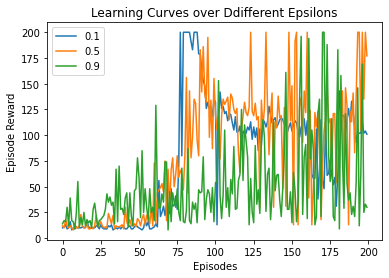

In [ ]:
from matplotlib import pyplot as plt
 
# Load environment 
env_name = 'CartPole-v0'
env = gym.make(env_name)

# Hyperparameters
epsilons = [0.1, 0.5, 0.9]

# Train
for _epsilon in epsilons:
  agent = DQN(env, discount=0.99, epsilon=_epsilon)
  episodes_rewards = agent.train()
  plt.plot(episodes_rewards)

plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.title('Learning Curves over Ddifferent Epsilons')
plt.legend(epsilons)
plt.show()
